### Giovanni Gamaliel López Padilla
### Procesamiento de lenguaje natural
### Practica 3: Bolsas de términos y esquemas de pesado

In [1]:
import os
import re
from keras.preprocessing.text import Tokenizer


def get_texts_from_file(path_corpus: str, path_truth: str):
    tr_txt = []
    tr_y = []
    with open(path_corpus, "r") as f_corpus, open(path_truth, "r") as f_truth:
        for twitt in f_corpus:
            tr_txt += [twitt]
        for label in f_truth:
            tr_y += [label]
    return tr_txt, tr_y

In [2]:
parameters = {"path data": "../Data/",
              "text file train": "mex_train.txt",
              "text file labels": "mex_train_labels.txt",
              "text file validation": "mex_val.txt",
              "text file validation labels": "mex_val_labels.txt"}
path_corpus = "{}{}".format(parameters["path data"],
                            parameters["text file train"])
path_truth = "{}{}".format(parameters["path data"],
                           parameters["text file labels"])
tr_txt, tr_y = get_texts_from_file(path_corpus,
                                   path_truth)
tr_y = list(map(int, tr_y))

#### Estadisticas simples

Counter({0: 3563, 1: 1981})


Text(0.5, 0, 'Class')

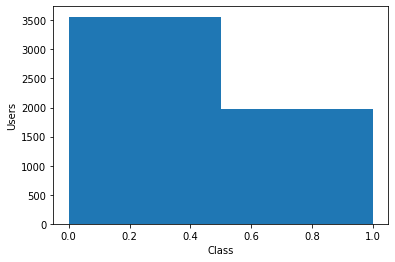

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
print(Counter(tr_y))
plt.hist(tr_y, bins=len(set(tr_y)))
plt.ylabel("Users")
plt.xlabel("Class")

### Un ojo a los datos

In [4]:
tr_txt[:100]

['lo peor de todo es que no me dan por un tiempo y luego vuelven estoy hasta la verga de estl\n',
 'a la vga no seas mamón 45 putos minutos después me dices que apenas sales no me querías avisar en 3 horas? 😑\n',
 'considero que lo más conveniente seria que lo retes a unos vergazos mi jelipe! rómpele la madre a ese pinchi joto!\n',
 'el marica de mi ex me tiene bloqueada de todo así  uno no puede admirar la "belleza" de su garnacha 😂\n',
 'mujer despechadaya pinche amlo hazle esta que se pela la loca #reynosafollow #reynosa\n',
 'putos. no tienen madre. ambriados mantenidos. ojetes. como es posible. mejor matarlos\n',
 'ustedes si puden andar de chanceros pero cuidadito y seamos nosotras porque luego luego empiezan a mamar hijos de la chingada.\n',
 '@usuario jajjaja te digo esa madre si está buena ajjaja\n',
 'odio los putos trámites de titulación 😡😡😡😡😡😡😡😡😡😡😡 pero me urge la precedula.\n',
 '@usuario no te equivocabas mi madre y tu tenían muchísima razón siempre es mejor lo que viene 

## Construcción simple del vocabulario

In [5]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

In [6]:
import nltk
corpus_palabras = []
for doc in tr_txt:
    corpus_palabras += tokenizer.tokenize(doc)
fdist = nltk.FreqDist(corpus_palabras)

In [7]:
fdist

FreqDist({'que': 3383, 'de': 3357, '.': 2774, 'a': 2629, 'la': 2433, 'y': 2266, 'no': 1824, 'me': 1613, '!': 1505, 'el': 1303, ...})

In [8]:
len(fdist)

13581

In [9]:
def sort_freqdist(fdist: nltk.FreqDist):
    aux = [(fdist[key], key) for key in fdist]
    aux.sort()
    aux.reverse()
    return aux

In [10]:
v = sort_freqdist(fdist)

In [11]:
v = v[:5000]

In [12]:
dict_indices = dict()
cont = 0
for weight, word in v:
    dict_indices[word] = cont
    cont += 1

#### Bolsa de palabras

In [13]:
import numpy as np


def build_bow(tr_txt: list, v: list, dict_indices: dict):
    bow = np.zeros((len(tr_txt), len(v)), dtype=int)
    cont_doct = 0
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))
        for word in fdist_doc:
            if word in dict_indices.keys():
                bow[cont_doct, dict_indices[word]] = 1
        cont_doct += 1
    return bow

In [14]:
bow_tr = build_bow(tr_txt,
                   v,
                   dict_indices)

In [15]:
bow_tr.shape

(5544, 5000)

### Bolsa de terminos de validacion

Counter({0: 397, 1: 219})


Text(0.5, 0, 'Class')

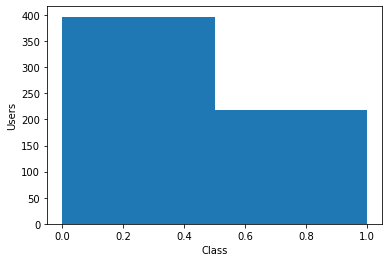

In [17]:
path_validation = "{}{}".format(parameters["path data"],
                                parameters["text file validation"])
path_validation_truth = "{}{}".format(parameters["path data"],
                                      parameters["text file validation labels"])
val_txt, val_y = get_texts_from_file(path_validation,
                                     path_validation_truth)
val_y = list(map(int, val_y))
print(Counter(val_y))
%matplotlib inline
plt.hist(val_y, bins=len(set(val_y)))
plt.ylabel("Users")
plt.xlabel("Class")

In [23]:
bow_val = build_bow(val_txt,
                   v,
                   dict_indices)

### Clasificacion

In [26]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score
parameters_model = {"C": [0.05, 0.12, 0.25, 0.5, 1, 2, 4]}
svr = svm.LinearSVC(class_weight="balanced")
grid = GridSearchCV(estimator=svr,
                    param_grid=parameters_model,
                    n_jobs=8,
                    scoring="f1_macro",
                    cv=5)
grid.fit(bow_tr, tr_y)
y_pred = grid.predict(bow_val)

In [27]:
p, r, f ,_= precision_recall_fscore_support(val_y,
                                          y_pred,
                                          average="macro",
                                          pos_label=1)
print(confusion_matrix(val_y,y_pred))
print(metrics.classification_report(val_y,y_pred))

[[329  68]
 [ 47 172]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       397
           1       0.72      0.79      0.75       219

    accuracy                           0.81       616
   macro avg       0.80      0.81      0.80       616
weighted avg       0.82      0.81      0.82       616



In [28]:
incorrect = [] 
for e in zip(val_y,y_pred,range(len(val_y))):
    if e[0] !=e[1]:
        incorrect += [e[2]]

In [29]:
for case in incorrect:
    if "madre" in val_txt[case].strip():
        print("Texto: {}\nTruth: {}\nPred: {}".format(val_txt[case].strip(),
                                                     val_y[case],
                                                     y_pred[case]))
    

Texto: cada día me siento como un perro ovejero tratando de cuidar sus ovejas vale madre pinches rateros póngase a trabajar.😤
Truth: 1
Pred: 0
Texto: ya a cualquier prieto le dicen licenciado peludito tengan madre
Truth: 1
Pred: 0
Texto: ahora si a chingar a su madre la fecha fifa y ahora si a disfrutar de nuestra gloriosa liga mx.
Truth: 0
Pred: 1
Texto: la neta... si yo fuera messi les dijera "chinguen a su madre putos yo hice todo".
Truth: 0
Pred: 1
Texto: no quería mentarte la madre tan temprano pinche maricón il "buasap" pinche millenial cacha moscas
Truth: 1
Pred: 0
Texto: los putos a chin.... a su madre! ya me harté de seguir todo el mundo seguiré lo que yo quiera.
Truth: 1
Pred: 0
Texto: @usuario no tienen abuela madre vergüenza....
Truth: 1
Pred: 0
Texto: chingas a tu madre sí no cumples la promesa que me hiciste hace tiempo.
Truth: 1
Pred: 0
Texto: dicen que el amor es de putos! y pues q puto resulte  jajaja valí madre desde que la conocí!
Truth: 0
Pred: 1
Texto: prácticament